# Example Notebook: Atom Mappings
In this example we want to showcase how to generate the Kartograf mappings on 
the RHFE Data set, which was used for our publication.

## Get Data:
In this cell we will load the molecules as components from openfe-benchmarks

  Cloning https://github.com/OpenFreeEnergy/openfe-benchmarks.git to /tmp/pip-req-build-dsih_khc
  Running command git clone --filter=blob:none --quiet https://github.com/OpenFreeEnergy/openfe-benchmarks.git /tmp/pip-req-build-dsih_khc
  Resolved https://github.com/OpenFreeEnergy/openfe-benchmarks.git to commit d81c79273b88f9b3baddd9886097789151e3df39
  Preparing metadata (setup.py) ... done
  Created wheel for openfe-benchmarks: filename=openfe_benchmarks-0.0.0-py2.py3-none-any.whl size=1338664 sha256=156abe05cd092abb61d261190aa89c60dc9084f1ad2bb96e4ecba6eaf90e1c1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jp81fv_5/wheels/3d/2e/0d/a9d202ebefb2df685d9ab7255081f70a7ace5ff45bcdd698d2
Successfully built openfe-benchmarks


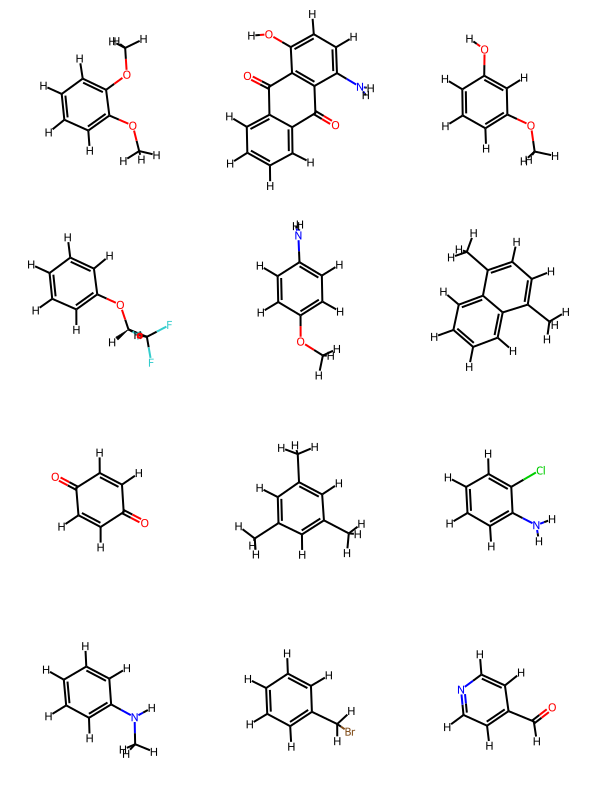

In [2]:
import sys

from rdkit import Chem
try:
    from openfe_benchmarks import benzenes
except ModuleNotFoundError:
    !{sys.executable} -m pip install --no-deps git+https://github.com/OpenFreeEnergy/openfe-benchmarks.git
    from openfe_benchmarks import benzenes
    

components = benzenes.get_system().ligand_components

# Exclude cycle breakers! as not feasible for Hybrid topology approaches.
not_lig = ["lig_4", "lig_7", "lig_2", "lig_3"]
components = [c for c in components if(c.name not in not_lig)]

Chem.Draw.MolsToGridImage([c.to_rdkit() for c in components])


## Generate Atom Mappings with Kartograf:
Next we will generate all possible atom mappings, for the given Ligand cA.

In [3]:
from kartograf import KartografAtomMapper

atomMapper = KartografAtomMapper()

#Generate Mappings
mappings = []
cA=components[-5] # central ligand from Ries et al. 2022
for cB in components:
    if(cA != cB):
        mapping = next(atomMapper.suggest_mappings(cA, cB))
        mappings.append(mapping)

INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO

In [5]:
from kartograf.utils.mapping_visualization_widget import display_mappings_3d
display_mappings_3d(mappings)

## Scoring Metrics for Atom mappings:
Finally we want to compare the different mappings with rule-based scoring 
methods. This way we can try to estimate the complexity of the transformation
 from cA to cB.

In [6]:
from kartograf.atom_mapping_scorer import ( DefaultKartografScorer,
                                            MappingVolumeRatioScorer, MappingRMSDScorer,
                                            MappingShapeOverlapScorer, MappingShapeMismatchScorer)

scorer_dict ={
    "score": DefaultKartografScorer(),
    "volume_score": MappingVolumeRatioScorer(),
    "rmsd_score": MappingRMSDScorer(),
    "overlap_score": MappingShapeOverlapScorer(),
    "mismatch_score": MappingShapeMismatchScorer()
}

def apply_scorers(mapping):
    for score_name, scorer in scorer_dict.items():
        setattr(mapping, score_name, scorer(mapping))

#score mappings:
for mapping in mappings:
    apply_scorers(mapping)



INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.03668860669135393	weight0.1
INFO:		MappingShapeOverlapScorer	0.40062401421093313	weight0.3
INFO:		MappingShapeMismatchScorer	0.2409970977283412	weight0.3
INFO:		MappingRMSDScorer	0.6452919559154746	weight0.3
INFO:	Result: 0.39
INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.23806696397460175	weight0.1
INFO:		MappingShapeOverlapScorer	0.43452822321367934	weight0.3
INFO:		MappingShapeMismatchScorer	0.17922442731548702	weight0.3
INFO:		MappingRMSDScorer	0.614023612053613	weight0.3
INFO:	Result: 0.39
INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.1204994724397427	weight0.1
INFO:		MappingShapeOverlapScorer	0.34406318583709794	weight0.3
INFO:		MappingShapeMismatchScorer	0.16109141920243517	weight0.3
INFO:		MappingRMSDScorer	0.5809132541787193	weight0.3
INFO:	Result: 0.34
INFO:	Kartograf Score:
INFO:		MappingVolumeRatioScorer	0.03667657372013587	weight0.1
INFO:		MappingShapeOverlapScorer	0.42969902676343835	weight0.3


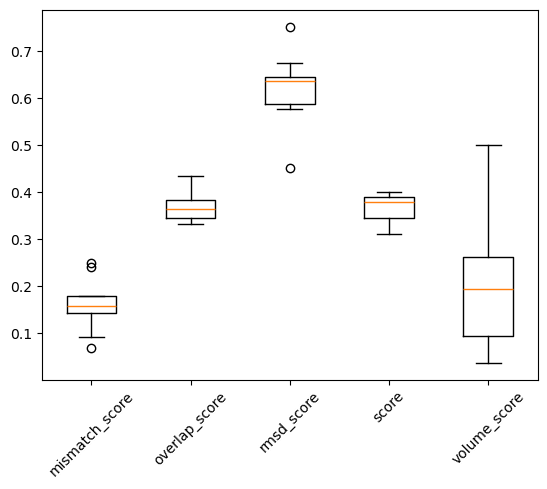

In [7]:
from matplotlib import pyplot as plt

score_names = sorted(scorer_dict)
plt.boxplot([[getattr(m, score_name) for m in mappings] for score_name in score_names])
plt.xticks(range(1, len(score_names)+1), score_names, rotation=45);

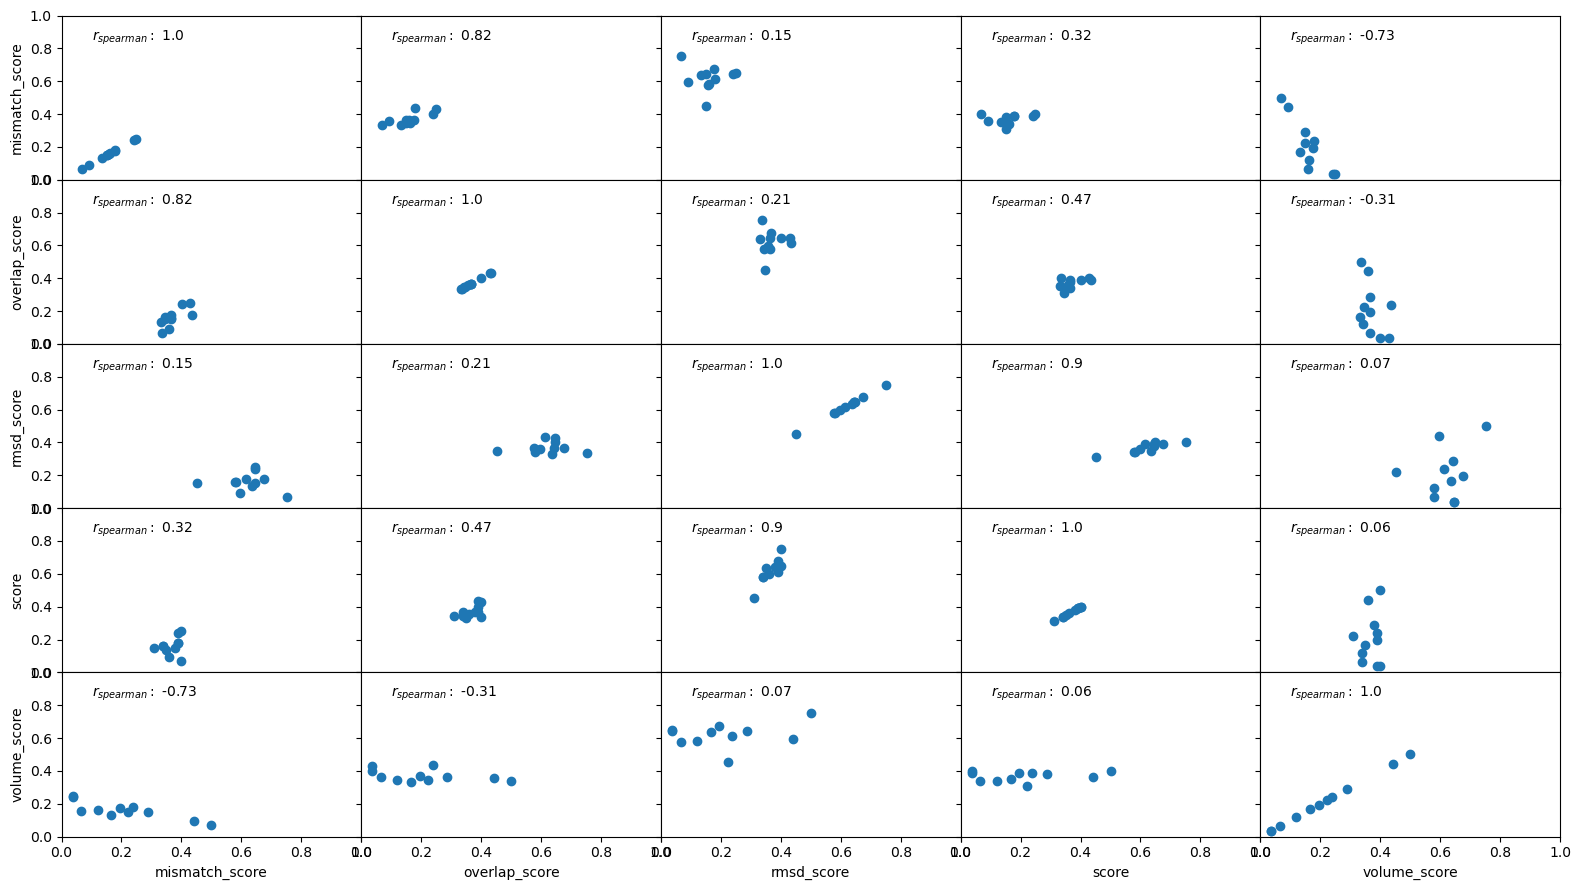

In [8]:
from scipy.stats import spearmanr
from matplotlib import pyplot as plt

score_names = sorted(scorer_dict)
fig, axes = plt.subplots(nrows=len(score_names), ncols=len(score_names), figsize=[16,9])

i=0
for score_nameA in score_names:
    j=0
    axes[i,j].set_ylabel(score_nameA)

    for score_nameB in score_names:
        ax = axes[i,j]
        if(i == len(score_names)-1):
            ax.set_xlabel(score_nameB)
        else:
            ax.set_xticklabels([])
        if(j>0):
            ax.set_yticklabels([])


        x = [getattr(m, score_nameA) for m in mappings]
        y = [getattr(m, score_nameB) for m in mappings]
        r, _ = spearmanr(x,y)
        ax.scatter(x,y)
        ax.text(0.1,0.85, "$r_{spearman}:~$"+str(round(r,2)))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])

        j+=1
    i+=1
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
